In [1]:
import sys
import os
from ml4cvd.arguments import parse_args
from ml4cvd.models import make_multimodal_multitask_model, saliency_map
from ml4cvd.tensor_generators import test_train_valid_tensor_generators, big_batch_from_minibatch_generator
from ml4cvd.recipes import run
import h5py
import numpy as np
import matplotlib
# font = {'family' : 'Arial',
#         'size'   : 30}
# matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
from typing import List, Dict, Callable
from collections import defaultdict
import pandas as pd

from ml4cvd.arguments import _get_tmap
from ml4cvd.TensorMap import TensorMap
from ml4cvd.tensor_from_file import TMAPS

import numpy as np
USER = 'pdiachil'
HOME_PATH = '/home/' + USER

/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '
Using TensorFlow backend.


In [ ]:
sys.argv = ['train',
            '--mode', 'train',
            '--output_folder', f'{HOME_PATH}/ukbb_output/',
            '--tensors', f'/mnt/disks/ecg-rest-37k-tensors/2019-11-04/',
            '--input_tensors', 'ecg_rest',
            '--output_tensors', 'qrs-duration', 'p-duration', 'qt-interval', 'pq-interval', 'rr-interval',
            '--id', 'ecg_rest_pretraining_intervals',
            '--inspect_model',
            '--training_steps', '810',
            '--validation_steps', '230',
            '--test_steps', '115',
            '--batch_size', '32',
            '--epochs', '3',
            '--patience', '12'            
           ]
args = parse_args()

In [ ]:
run(args)

In [ ]:
sys.argv = ['infer',
            '--mode', 'infer',
            '--output_folder', f'{HOME_PATH}/ukbb_output/',
            '--tensors', f'/mnt/disks/ecg-rest-37k-tensors/2019-11-04/',
            '--input_tensors', 'ecg_rest',
            '--output_tensors', 'qrs-duration', 'p-duration', 'qt-interval', 'pq-interval', 'rr-interval',
            '--id', 'ecg_rest_pretraining_intervals',
            '--model_file', f'{HOME_PATH}/ukbb_output/ecg_rest_pretraining_intervals/ecg_rest_pretraining_intervals.hd5',
            '--training_steps', '810',
            '--validation_steps', '230',
            '--test_steps', '115',
            '--batch_size', '32',
            '--epochs', '1',
            '--patience', '12'            
           ]
args = parse_args()

In [ ]:
import shutil
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(keep_paths=True, **args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)
for gen in [generate_train, generate_valid, generate_test]:
    data_len = gen.true_epoch_lens[0]
    cnt = 0
    for (data, labels, paths) in gen: 
        if cnt >= data_len: break
        in_tensor = data[args.tensor_maps_in[0].input_name()]
        for tm in args.tensor_maps_out:
            for channel in tm.channel_map:
                gradients = saliency_map(in_tensor, model, tm.output_name(), tm.channel_map[channel])
                for i, path in enumerate(paths):
                    fname = os.path.basename(path)
                    if not os.path.isfile(os.path.join('/mnt/disks/ecg-rest-37k-tensors-saliency/2020-02-03/', fname)):
                        shutil.copy(path, os.path.join('/mnt/disks/ecg-rest-37k-tensors-saliency/2020-02-03/', fname))
                    with h5py.File(os.path.join(args.output_folder, fname)) as hd5:
                        try:
                            hd5.create_dataset(f'{args.tensor_maps_in[0].group}/{tm.group}/{tm.input_name()}_saliency',
                                               data = gradients[i, :, :])            
                        except RuntimeError as e:
                            print(f'{args.tensor_maps_in[0].group}/{tm.group}/{tm.input_name()}_saliency already exists in {fname}')        
        cnt += len(paths)

In [ ]:
def plot_saliency(hd5, in_name, out_name):
    in_tmap = _get_tmap(in_name)
    out_tmap = _get_tmap(out_name)
    in_tensor = in_tmap.tensor_from_file(in_tmap, hd5)
    print()
    out_tensor = np.array(hd5[f'{in_tmap.group}/{out_tmap.group}/{out_tmap.input_name()}_saliency'])
    f, ax = plt.subplots()
    f.set_size_inches(16, 9)
    ax.plot(in_tensor[:, 0])
    ax.plot(np.abs(out_tensor[:, 0]))

In [ ]:
%matplotlib inline
with h5py.File('/mnt/disks/ecg-rest-37k-tensors-saliency/2020-02-03/1000503.hd5') as hd5:
    plot_saliency(hd5, 'ecg_rest', 'pq-interval')

# Learn saliency maps

In [ ]:
sys.argv = ['train',
            '--mode', 'train',
            '--output_folder', f'{HOME_PATH}/ukbb_output/',
            '--tensors', f'/mnt/disks/ecg-rest-37k-tensors-saliency/2020-02-03/',
            '--input_tensors', 'ecg_rest',
            '--output_tensors', 'ecg_rest_saliency',
            '--id', 'ecg_rest_pretraining_intervals',
            '--model_file', f'{HOME_PATH}/ukbb_output/ecg_rest_pretraining_intervals/ecg_rest_pretraining_intervals.hd5',
            '--training_steps', '810',
            '--validation_steps', '230',
            '--test_steps', '115',
            '--batch_size', '32',
            '--epochs', '1',
            '--patience', '12'            
           ]
args = parse_args()

# Learn under the mask

In [5]:
sys.argv = ['train',
            '--mode', 'train',
            '--output_folder', f'{HOME_PATH}/ukbb_output/',
            '--tensors', f'/mnt/disks/ecg-rest-37k-tensors/2019-11-04/',
            '--input_tensors', 'ecg_rest_masked',
            '--output_tensors', 'ecg_rest_output',
            '--u_connect',
            '--inspect_model',
            '--id', 'ecg_rest_pretraining_mask',
            '--training_steps', '810',
            '--validation_steps', '230',
            '--test_steps', '115',
            '--batch_size', '32',
            '--epochs', '1',
            '--patience', '12'            
           ]
args = parse_args()

2020-02-04 23:12:17,230 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at /home/pdiachil/ukbb_output/ecg_rest_pretraining_mask/log_2020-02-04_23-12_0.log.
2020-02-04 23:12:17,232 - arguments:211 - INFO - Command Line was:

./scripts/tf.sh train --mode train --output_folder /home/pdiachil/ukbb_output/ --tensors /mnt/disks/ecg-rest-37k-tensors/2019-11-04/ --input_tensors ecg_rest_masked --output_tensors ecg_rest_output --u_connect --inspect_model --id ecg_rest_pretraining_mask --training_steps 810 --validation_steps 230 --test_steps 115 --batch_size 32 --epochs 1 --patience 12



2020-02-04 23:12:17,233 - arguments:212 - INFO - Total TensorMaps:400 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=32, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='br

In [6]:
run(args)

2020-02-04 23:12:19,578 - tensor_generators:426 - INFO - Found 23852 train, 6654 validation, and 7117 testing tensors at: /mnt/disks/ecg-rest-37k-tensors/2019-11-04/
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_masked_strip_ecg_rest (In (None, 5000, 8, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5000, 8, 32)  320         input_masked_strip_ecg_rest[0][0]
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 5000, 8, 32)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)        

Epoch 1/1
2020-02-04 23:12:23,345 - tensor_generators:110 - INFO - Starting validation_worker_0.
2020-02-04 23:12:23,346 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-04 23:12:23,349 - tensor_generators:234 - INFO - validation_worker_0 initialized cache of size 0.875 GB.
2020-02-04 23:12:23,352 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.875 GB.
2020-02-04 23:12:23,363 - tensor_generators:110 - INFO - Starting validation_worker_1.
2020-02-04 23:12:23,380 - tensor_generators:234 - INFO - validation_worker_1 initialized cache of size 0.875 GB.
2020-02-04 23:12:23,381 - tensor_generators:110 - INFO - Starting train_worker_1.
2020-02-04 23:12:23,387 - tensor_generators:234 - INFO - train_worker_1 initialized cache of size 0.875 GB.
2020-02-04 23:12:23,414 - tensor_generators:110 - INFO - Starting train_worker_2.
2020-02-04 23:12:23,434 - tensor_generators:234 - INFO - train_worker_2 initialized cache of size 0.875 GB.
2020-02-04 23:12:23,

KeyboardInterrupt: 

In [9]:
sys.argv = ['infer',
            '--mode', 'infer',
            '--output_folder', f'{HOME_PATH}/ukbb_output/',
            '--tensors', f'/mnt/disks/ecg-rest-37k-tensors/2019-11-04/',
            '--input_tensors', 'ecg_rest_masked',
            '--output_tensors', 'ecg_rest_output',
            '--model_file', f'/home/pdiachil/ukbb_output/ecg_rest_pretraining_mask/ecg_rest_pretraining_mask.hd5',
            '--u_connect',
            '--id', 'ecg_rest_pretraining_mask_infer',
            '--training_steps', '810',
            '--validation_steps', '230',
            '--test_steps', '115',
            '--batch_size', '32',
            '--epochs', '10',
            '--patience', '12'            
           ]
args = parse_args()

2020-02-04 23:13:59,301 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at /home/pdiachil/ukbb_output/ecg_rest_pretraining_mask_infer/log_2020-02-04_23-13_0.log.
2020-02-04 23:13:59,303 - arguments:211 - INFO - Command Line was:

./scripts/tf.sh infer --mode infer --output_folder /home/pdiachil/ukbb_output/ --tensors /mnt/disks/ecg-rest-37k-tensors/2019-11-04/ --input_tensors ecg_rest_masked --output_tensors ecg_rest_output --model_file /home/pdiachil/ukbb_output/ecg_rest_pretraining_mask/ecg_rest_pretraining_mask.hd5 --u_connect --id ecg_rest_pretraining_mask_infer --training_steps 81 --validation_steps 23 --test_steps 115 --batch_size 32 --epochs 10 --patience 12



2020-02-04 23:13:59,304 - arguments:212 - INFO - Total TensorMaps:400 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, anneal_max=1.0, anneal_rate=1.0, anneal_shift=10, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=32, bigquery_credentials_file='/

In [10]:
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(keep_paths=True, **args.__dict__)
model = make_multimodal_multitask_model(**args.__dict__)

2020-02-04 23:14:00,504 - tensor_generators:426 - INFO - Found 23852 train, 6654 validation, and 7117 testing tensors at: /mnt/disks/ecg-rest-37k-tensors/2019-11-04/
2020-02-04 23:14:00,583 - models:615 - INFO - Attempting to load model file from: /home/pdiachil/ukbb_output/ecg_rest_pretraining_mask/ecg_rest_pretraining_mask.hd5


OSError: Unable to open file (unable to open file: name = '/home/pdiachil/ukbb_output/ecg_rest_pretraining_mask/ecg_rest_pretraining_mask.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

2020-02-04 23:10:52,666 - tensor_generators:110 - INFO - Starting train_worker_0.
2020-02-04 23:10:52,667 - tensor_generators:234 - INFO - train_worker_0 initialized cache of size 0.875 GB.
2020-02-04 23:10:52,681 - tensor_generators:110 - INFO - Starting train_worker_1.
2020-02-04 23:10:52,685 - tensor_generators:234 - INFO - train_worker_1 initialized cache of size 0.875 GB.
2020-02-04 23:10:52,695 - tensor_generators:110 - INFO - Starting train_worker_2.
2020-02-04 23:10:52,700 - tensor_generators:234 - INFO - train_worker_2 initialized cache of size 0.875 GB.
2020-02-04 23:10:52,711 - tensor_generators:110 - INFO - Starting train_worker_3.
2020-02-04 23:10:52,716 - tensor_generators:234 - INFO - train_worker_3 initialized cache of size 0.875 GB.


NameError: name 'model' is not defined

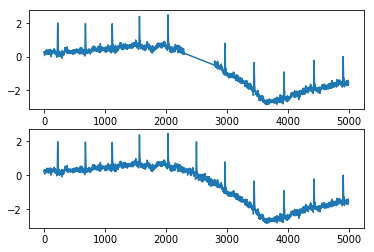

In [4]:
%matplotlib inline
for gen in [generate_train, generate_valid, generate_test]:
    cnt = 0
    for (data, labels, paths) in gen: 
        in_tensor = data[args.tensor_maps_in[0].input_name()]
        label_tensor = labels[args.tensor_maps_out[0].output_name()]
        f, ax = plt.subplots(2, 1)
        ax[0].plot(in_tensor[0, :, 0])
        ax[1].plot(label_tensor[0, :, 0])
        out_tensor = model.predict(in_tensor)
        ax[0].plot(out_tensor[0, :, 0])
        break
    break